# Traditional Baselines: Linear Regression, ARIMA, Random Forest

This notebook implements traditional ML baselines for community health prediction:
- **Linear Regression**: Simple linear model on flattened features
- **ARIMA**: Time series forecasting per community
- **Random Forest**: Ensemble method on aggregated graph features

Uses the **same data split and normalization** as the GNN training notebook to ensure fair comparison.

## 1. Setup and Imports

In [3]:
import sys
import numpy as np
import pandas as pd
import torch
from pathlib import Path
from datetime import datetime
from dateutil.relativedelta import relativedelta
from typing import List, Dict, Tuple
from tqdm.auto import tqdm
from functools import lru_cache
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pickle
import random
import warnings
warnings.filterwarnings('ignore')

# Sklearn imports
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ARIMA imports
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

# Paths
GRAPH_DIR = Path('../data/processed/graphs')
RESULTS_DIR = Path('../results/baseline')
PROJECT_DIR = Path('..')

# Create results directory
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

print(f"Graph directory: {GRAPH_DIR}")
print(f"Results directory: {RESULTS_DIR}")

Graph directory: ../data/processed/graphs
Results directory: ../results/baseline


## 2. Define Temporal Dataset (Same as GNN Training)

We use the same dataset structure as the GNN training notebook to ensure fair comparison.

In [4]:
class FastTemporalDataset:
    """
    Dataset with lazy loading + LRU cache + target normalization.
    Same as GNN training notebook for fair comparison.
    
    - No slow pre-caching step (starts training immediately)
    - LRU cache automatically keeps hot graphs in memory
    - Stratified sampling for representative coverage
    - Starts from 2014 (skips noisy early years)
    - Target normalization: Standardizes all targets to mean=0, std=1
    """

    def __init__(
        self,
        graph_dir: Path,
        split: str = 'train',
        sequence_length: int = 12,
        prediction_horizon: int = 6,
        max_samples: int = None,
        cache_size: int = 2000,
        stratified_sample: bool = True
    ):
        self.graph_dir = Path(graph_dir)
        self.split = split
        self.sequence_length = sequence_length
        self.prediction_horizon = prediction_horizon

        # Temporal splits (start from 2014 to skip noisy early years)
        self.split_ranges = {
            'train': ('2014-01', '2020-06'),  # Predict through 2020-12
            'val':   ('2020-07', '2022-09'),  # Predict through 2023-03
            'test':  ('2022-10', '2023-09')   # Predict through 2024-03
        }

        # Build sample index
        print(f"Building {split} sample index...")
        self.samples = self._build_sample_index()
        print(f"  Found {len(self.samples)} potential samples")

        # Apply sampling strategy
        if max_samples and len(self.samples) > max_samples:
            if stratified_sample:
                print(f"  Applying stratified sampling to select {max_samples} samples...")
                self.samples = self._stratified_sample(max_samples)
            else:
                print(f"  Randomly sampling {max_samples} samples...")
                random.shuffle(self.samples)
                self.samples = self.samples[:max_samples]

        print(f"{split.upper()} Dataset: {len(self.samples)} samples")

        # Initialize normalization stats (will be set externally for consistency)
        self.norm_stats = None

        # Create LRU cached loader for individual monthly graphs
        @lru_cache(maxsize=cache_size)
        def _cached_load(community: str, month: str):
            path = self.graph_dir / community / f"{month}.pt"
            return torch.load(path, weights_only=False, map_location='cpu')

        self._load_graph = _cached_load

    def compute_normalization_stats(self):
        """
        Compute mean and std for each target metric from training data.
        IMPORTANT: Only call this on the training dataset.
        """
        print("\n" + "="*70)
        print("Computing target normalization statistics")
        print("="*70)
        print("Sampling up to 1000 examples to compute statistics...")

        all_targets = {'qpd': [], 'answer_rate': [], 'retention': []}

        # Sample up to 1000 examples for statistics
        sample_size = min(1000, len(self.samples))
        sample_indices = np.random.choice(len(self.samples), sample_size, replace=False)

        for idx in tqdm(sample_indices, desc='Sampling targets'):
            sample = self.samples[idx]
            target_graph = self._load_graph(sample['community'], sample['target_month'])
            targets = target_graph.y

            for key in all_targets:
                if key in targets:
                    all_targets[key].append(float(targets[key]))

        # Compute mean and std for each metric
        self.norm_stats = {}
        for key in all_targets:
            if len(all_targets[key]) > 0:
                values = np.array(all_targets[key])
                self.norm_stats[key] = {
                    'mean': float(values.mean()),
                    'std': float(values.std() + 1e-8)
                }

        print("\nNormalization statistics (computed from training data):")
        print(f"{'Metric':<15} {'Mean':<12} {'Std':<12}")
        print("-" * 39)
        for key in all_targets:
            if key in self.norm_stats:
                print(f"{key:<15} {self.norm_stats[key]['mean']:<12.4f} {self.norm_stats[key]['std']:<12.4f}")

        return self.norm_stats

    def _build_sample_index(self) -> List[Dict]:
        """Build index of all valid temporal sequences."""
        samples = []
        start_month, end_month = self.split_ranges[self.split]
        min_graphs = self.sequence_length + self.prediction_horizon

        for community_dir in sorted(self.graph_dir.iterdir()):
            if not community_dir.is_dir():
                continue

            available_months = sorted([f.stem for f in community_dir.glob('*.pt')])
            if len(available_months) < min_graphs:
                continue

            for i, month_t in enumerate(available_months):
                # Check if month is in split range
                if not (start_month <= month_t <= end_month):
                    continue
                if i < self.sequence_length - 1:
                    continue

                target_idx = i + self.prediction_horizon
                if target_idx >= len(available_months):
                    continue

                seq_start = i - self.sequence_length + 1
                seq_months = available_months[seq_start:i+1]
                target_month = available_months[target_idx]

                # Check temporal consistency
                if self._is_consecutive(seq_months, target_month):
                    samples.append({
                        'community': community_dir.name,
                        'sequence_months': seq_months,
                        'target_month': target_month
                    })

        return samples

    def _is_consecutive(self, seq_months, target_month):
        """Check if months form consecutive sequence."""
        try:
            dates = [datetime.strptime(m, '%Y-%m') for m in seq_months]
            for i in range(1, len(dates)):
                if dates[i] != dates[i-1] + relativedelta(months=1):
                    return False
            target_date = datetime.strptime(target_month, '%Y-%m')
            expected = dates[-1] + relativedelta(months=self.prediction_horizon)
            return target_date == expected
        except:
            return False

    def _stratified_sample(self, n_samples: int) -> List[Dict]:
        """
        Create stratified sample across communities.
        Ensures representative distribution across small/medium/large communities.
        """
        # Group by community
        by_community = defaultdict(list)
        for sample in self.samples:
            by_community[sample['community']].append(sample)

        # Sample proportionally from each community
        samples_per_community = max(1, n_samples // len(by_community))
        selected = []

        for community, comm_samples in by_community.items():
            n = min(samples_per_community, len(comm_samples))
            selected.extend(random.sample(comm_samples, n))

        # Trim to exact size and shuffle
        random.shuffle(selected)
        return selected[:n_samples]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        community = sample['community']

        # Load sequence using cached loader
        graphs = [
            self._load_graph(community, month)
            for month in sample['sequence_months']
        ]

        target_graph = self._load_graph(community, sample['target_month'])
        targets = target_graph.y

        return graphs, targets, sample

## 3. Load or Create Shared Configuration

This ensures we use the **exact same train/val samples** and **normalization statistics** as the GNN training.

In [5]:
# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

# Path to shared config
CONFIG_PATH = PROJECT_DIR / 'results' / 'baseline_config.pkl'

if CONFIG_PATH.exists():
    print("Loading existing baseline config (same as GNN training)...")
    with open(CONFIG_PATH, 'rb') as f:
        config = pickle.load(f)
    print(f"  Train samples: {len(config['train_samples'])}")
    print(f"  Val samples: {len(config['val_samples'])}")
    print(f"  Normalization stats: {list(config['norm_stats'].keys())}")
    
    # Print normalization stats
    print("\nNormalization Statistics:")
    for key, stats in config['norm_stats'].items():
        print(f"  {key}: mean={stats['mean']:.4f}, std={stats['std']:.4f}")
else:
    print("Creating new baseline config...")
    print("  Building full sample index (this may take a moment)...")
    
    # Create temporary datasets to get all samples
    temp_train = FastTemporalDataset(GRAPH_DIR, split='train', max_samples=None, stratified_sample=False)
    temp_val = FastTemporalDataset(GRAPH_DIR, split='val', max_samples=None, stratified_sample=False)
    
    # Apply stratified sampling for train (2000 samples)
    print("  Applying stratified sampling for train set (2000 samples)...")
    train_samples = temp_train._stratified_sample(2000) if len(temp_train.samples) > 2000 else temp_train.samples
    
    # Apply stratified sampling for val (500 samples)
    print("  Applying stratified sampling for val set (500 samples)...")
    val_samples = temp_val._stratified_sample(500) if len(temp_val.samples) > 500 else temp_val.samples
    
    # Now set samples and compute normalization stats
    temp_train.samples = train_samples
    norm_stats = temp_train.compute_normalization_stats()
    
    # Save config
    config = {
        'train_samples': train_samples,
        'val_samples': val_samples,
        'norm_stats': norm_stats
    }
    
    CONFIG_PATH.parent.mkdir(parents=True, exist_ok=True)
    with open(CONFIG_PATH, 'wb') as f:
        pickle.dump(config, f)
    
    print(f"\nConfig saved to {CONFIG_PATH}")
    print(f"  Train samples: {len(train_samples)}")
    print(f"  Val samples: {len(val_samples)}")

Creating new baseline config...
  Building full sample index (this may take a moment)...
Building train sample index...
  Found 11020 potential samples
TRAIN Dataset: 11020 samples
Building val sample index...
  Found 4481 potential samples
VAL Dataset: 4481 samples
  Applying stratified sampling for train set (2000 samples)...
  Applying stratified sampling for val set (500 samples)...

Computing target normalization statistics
Sampling up to 1000 examples to compute statistics...


Sampling targets:   0%|          | 0/1000 [00:00<?, ?it/s]


Normalization statistics (computed from training data):
Metric          Mean         Std         
---------------------------------------
qpd             10.6292      25.2291     
answer_rate     0.4396       0.1452      
retention       0.2972       0.0991      

Config saved to ../results/baseline_config.pkl
  Train samples: 1834
  Val samples: 338


In [6]:
# Create datasets with the same samples as GNN training
train_dataset = FastTemporalDataset(
    graph_dir=GRAPH_DIR,
    split='train',
    max_samples=None,
    stratified_sample=False
)

val_dataset = FastTemporalDataset(
    graph_dir=GRAPH_DIR,
    split='val',
    max_samples=None,
    stratified_sample=False
)

# Override with the exact samples from config
train_dataset.samples = config['train_samples']
val_dataset.samples = config['val_samples']
train_dataset.norm_stats = config['norm_stats']
val_dataset.norm_stats = config['norm_stats']

print("\nDatasets configured with identical samples to GNN training")
print(f"  Train samples: {len(train_dataset.samples)}")
print(f"  Val samples: {len(val_dataset.samples)}")

Building train sample index...
  Found 11020 potential samples
TRAIN Dataset: 11020 samples
Building val sample index...
  Found 4481 potential samples
VAL Dataset: 4481 samples

Datasets configured with identical samples to GNN training
  Train samples: 1834
  Val samples: 338


## 4. Feature Extraction

Extract features from graph sequences for traditional ML models:
- **User statistics**: Mean/std of user features, count
- **Tag statistics**: Mean/std of tag features, count  
- **Temporal features**: Trends over the 12-month sequence
- **Historical targets**: Past values of target metrics

In [7]:
def extract_graph_features(graph) -> np.ndarray:
    """
    Extract aggregated features from a single graph.
    
    Returns a feature vector with:
    - User statistics: mean, std, min, max for each user feature + count
    - Tag statistics: mean, std, min, max for each tag feature + count
    - Edge statistics: edge counts
    """
    features = []
    
    # User features
    user_x = graph['user'].x.numpy()
    if len(user_x) > 0:
        features.extend(user_x.mean(axis=0))  # Mean of each feature
        features.extend(user_x.std(axis=0))   # Std of each feature
        features.append(len(user_x))          # User count
    else:
        features.extend([0] * (user_x.shape[1] * 2 + 1))
    
    # Tag features
    tag_x = graph['tag'].x.numpy()
    if len(tag_x) > 0:
        features.extend(tag_x.mean(axis=0))   # Mean of each feature
        features.extend(tag_x.std(axis=0))    # Std of each feature
        features.append(len(tag_x))           # Tag count
    else:
        features.extend([0] * (tag_x.shape[1] * 2 + 1))
    
    # Edge counts for different edge types
    for edge_type in [('user', 'posts_in', 'tag'), ('user', 'answers', 'user')]:
        if edge_type in graph.edge_types:
            features.append(graph[edge_type].edge_index.shape[1])
        else:
            features.append(0)
    
    # Graph-level target metrics (historical values)
    if hasattr(graph, 'y') and graph.y is not None:
        for key in ['qpd', 'answer_rate', 'retention']:
            if key in graph.y:
                features.append(float(graph.y[key]))
            else:
                features.append(0)
    else:
        features.extend([0, 0, 0])
    
    return np.array(features, dtype=np.float32)


def extract_sequence_features(graphs: List, include_trends: bool = True) -> np.ndarray:
    """
    Extract features from a sequence of 12 monthly graphs.
    
    Features include:
    - Aggregated features from last graph (most recent)
    - Mean features across sequence
    - Trend features (slope of key metrics over time)
    - Historical target values
    """
    # Extract features from each graph
    graph_features = [extract_graph_features(g) for g in graphs]
    graph_features = np.array(graph_features)
    
    features = []
    
    # Last graph features (most recent state)
    features.extend(graph_features[-1])
    
    # Mean features across sequence
    features.extend(graph_features.mean(axis=0))
    
    # Std features across sequence (variability)
    features.extend(graph_features.std(axis=0))
    
    if include_trends:
        # Compute linear trends for each feature
        x = np.arange(len(graphs))
        for i in range(graph_features.shape[1]):
            y = graph_features[:, i]
            if np.std(y) > 1e-8:
                slope = np.polyfit(x, y, 1)[0]
            else:
                slope = 0
            features.append(slope)
    
    return np.array(features, dtype=np.float32)


# Determine feature dimensions from a sample
sample_graphs, sample_targets, _ = train_dataset[0]
sample_features = extract_sequence_features(sample_graphs)
print(f"Feature dimension: {len(sample_features)}")
print(f"Sample features shape: {sample_features.shape}")

Feature dimension: 124
Sample features shape: (124,)


In [8]:
def extract_dataset_features(dataset, desc="Extracting"):
    """
    Extract features and targets from entire dataset.
    
    Returns:
        X: Feature matrix [n_samples, n_features]
        y: Target dict with arrays for each metric
        meta: Metadata (community, months) for each sample
    """
    X = []
    y = {'qpd': [], 'answer_rate': [], 'retention': []}
    meta = []
    
    for idx in tqdm(range(len(dataset)), desc=desc):
        graphs, targets, sample = dataset[idx]
        
        # Extract features
        features = extract_sequence_features(graphs)
        X.append(features)
        
        # Get targets
        for key in y:
            y[key].append(float(targets[key]))
        
        # Store metadata
        meta.append({
            'community': sample['community'],
            'target_month': sample['target_month'],
            'sequence_months': sample['sequence_months']
        })
    
    X = np.array(X)
    for key in y:
        y[key] = np.array(y[key])
    
    return X, y, meta


print("Extracting training features...")
X_train, y_train, meta_train = extract_dataset_features(train_dataset, "Train")

print("\nExtracting validation features...")
X_val, y_val, meta_val = extract_dataset_features(val_dataset, "Val")

print(f"\nTraining set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")

Extracting training features...


Train:   0%|          | 0/1834 [00:00<?, ?it/s]


Extracting validation features...


Val:   0%|          | 0/338 [00:00<?, ?it/s]


Training set: (1834, 124)
Validation set: (338, 124)


In [9]:
# Handle NaN and Inf values
def clean_features(X):
    """Replace NaN and Inf with 0."""
    X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
    return X

X_train = clean_features(X_train)
X_val = clean_features(X_val)

print(f"Training features - NaN count: {np.isnan(X_train).sum()}")
print(f"Validation features - NaN count: {np.isnan(X_val).sum()}")

Training features - NaN count: 0
Validation features - NaN count: 0


In [10]:
# Standardize features using training set statistics
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Also create normalized targets using the same stats as GNN
norm_stats = config['norm_stats']

y_train_norm = {}
y_val_norm = {}

for key in ['qpd', 'answer_rate', 'retention']:
    y_train_norm[key] = (y_train[key] - norm_stats[key]['mean']) / norm_stats[key]['std']
    y_val_norm[key] = (y_val[key] - norm_stats[key]['mean']) / norm_stats[key]['std']

print("Features and targets normalized")
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"X_val_scaled shape: {X_val_scaled.shape}")

Features and targets normalized
X_train_scaled shape: (1834, 124)
X_val_scaled shape: (338, 124)


## 5. Evaluation Functions

In [11]:
def evaluate_predictions(y_true, y_pred, metric_name=""):
    """
    Evaluate predictions on ORIGINAL scale.
    
    Returns:
        dict with MAE, RMSE, R2
    """
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    return {
        'mae': mae,
        'rmse': rmse,
        'r2': r2
    }


def denormalize_predictions(y_pred_norm, key):
    """Convert normalized predictions back to original scale."""
    return y_pred_norm * norm_stats[key]['std'] + norm_stats[key]['mean']


def print_results(results, model_name):
    """Pretty print evaluation results."""
    print(f"\n{'='*70}")
    print(f"{model_name} Results (on Original Scale)")
    print("="*70)
    print(f"{'Metric':<15} {'MAE':<12} {'RMSE':<12} {'R²':<12}")
    print("-"*51)
    
    mean_mae, mean_rmse, mean_r2 = 0, 0, 0
    for key in ['qpd', 'answer_rate', 'retention']:
        r = results[key]
        print(f"{key:<15} {r['mae']:<12.4f} {r['rmse']:<12.4f} {r['r2']:<12.4f}")
        mean_mae += r['mae']
        mean_rmse += r['rmse']
        mean_r2 += r['r2']
    
    print("-"*51)
    print(f"{'MEAN':<15} {mean_mae/3:<12.4f} {mean_rmse/3:<12.4f} {mean_r2/3:<12.4f}")
    print("="*70)

## 6. Linear Regression Baseline

Simple linear regression on aggregated graph features.

In [12]:
print("="*70)
print("Training Linear Regression Models")
print("="*70)

linear_models = {}
linear_results = {}
linear_predictions = {}

for target_key in ['qpd', 'answer_rate', 'retention']:
    print(f"\nTraining for {target_key}...")
    
    # Use Ridge regression for regularization
    model = Ridge(alpha=1.0)
    model.fit(X_train_scaled, y_train_norm[target_key])
    
    # Predict (normalized scale)
    y_pred_norm = model.predict(X_val_scaled)
    
    # Convert back to original scale for evaluation
    y_pred = denormalize_predictions(y_pred_norm, target_key)
    
    # Evaluate on original scale
    results = evaluate_predictions(y_val[target_key], y_pred, target_key)
    
    linear_models[target_key] = model
    linear_results[target_key] = results
    linear_predictions[target_key] = y_pred
    
    print(f"  R² = {results['r2']:.4f}, MAE = {results['mae']:.4f}")

print_results(linear_results, "Linear Regression")

Training Linear Regression Models

Training for qpd...
  R² = 0.9800, MAE = 1.8042

Training for answer_rate...
  R² = 0.4258, MAE = 0.0790

Training for retention...
  R² = 0.5342, MAE = 0.0532

Linear Regression Results (on Original Scale)
Metric          MAE          RMSE         R²          
---------------------------------------------------
qpd             1.8042       4.8542       0.9800      
answer_rate     0.0790       0.1180       0.4258      
retention       0.0532       0.0787       0.5342      
---------------------------------------------------
MEAN            0.6455       1.6836       0.6467      


## 7. Random Forest Baseline

Ensemble method that can capture non-linear relationships.

In [13]:
print("="*70)
print("Training Random Forest Models")
print("="*70)

rf_models = {}
rf_results = {}
rf_predictions = {}

for target_key in ['qpd', 'answer_rate', 'retention']:
    print(f"\nTraining for {target_key}...")
    
    # Random Forest (doesn't need normalized targets, but we use them for consistency)
    model = RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        n_jobs=-1,
        random_state=42
    )
    
    # Train on normalized targets
    model.fit(X_train_scaled, y_train_norm[target_key])
    
    # Predict (normalized scale)
    y_pred_norm = model.predict(X_val_scaled)
    
    # Convert back to original scale for evaluation
    y_pred = denormalize_predictions(y_pred_norm, target_key)
    
    # Evaluate on original scale
    results = evaluate_predictions(y_val[target_key], y_pred, target_key)
    
    rf_models[target_key] = model
    rf_results[target_key] = results
    rf_predictions[target_key] = y_pred
    
    print(f"  R² = {results['r2']:.4f}, MAE = {results['mae']:.4f}")

print_results(rf_results, "Random Forest")

Training Random Forest Models

Training for qpd...
  R² = 0.9578, MAE = 1.8535

Training for answer_rate...
  R² = 0.5043, MAE = 0.0760

Training for retention...
  R² = 0.5172, MAE = 0.0533

Random Forest Results (on Original Scale)
Metric          MAE          RMSE         R²          
---------------------------------------------------
qpd             1.8535       7.0495       0.9578      
answer_rate     0.0760       0.1096       0.5043      
retention       0.0533       0.0801       0.5172      
---------------------------------------------------
MEAN            0.6610       2.4131       0.6598      


In [14]:
# Feature importance analysis
print("\nTop 10 Important Features (Random Forest - QPD):")
importances = rf_models['qpd'].feature_importances_
indices = np.argsort(importances)[::-1][:10]

for i, idx in enumerate(indices):
    print(f"  {i+1}. Feature {idx}: {importances[idx]:.4f}")


Top 10 Important Features (Random Forest - QPD):
  1. Feature 28: 0.1805
  2. Feature 11: 0.1749
  3. Feature 59: 0.1369
  4. Feature 43: 0.1185
  5. Feature 72: 0.0969
  6. Feature 18: 0.0473
  7. Feature 54: 0.0465
  8. Feature 80: 0.0363
  9. Feature 41: 0.0260
  10. Feature 10: 0.0247


## 8. ARIMA Baseline

Time series forecasting that uses only historical values of the target metric.
ARIMA is fit per-community on the historical sequence.

In [15]:
def fit_arima_predict(series, horizon=6, order=(1, 1, 1)):
    """
    Fit ARIMA model and predict horizon steps ahead.
    
    Args:
        series: Historical time series (12 values)
        horizon: Steps to predict ahead
        order: ARIMA (p, d, q) order
    
    Returns:
        Predicted value at horizon
    """
    try:
        # Handle constant series
        if np.std(series) < 1e-8:
            return series[-1]
        
        # Fit ARIMA
        model = ARIMA(series, order=order)
        fitted = model.fit()
        
        # Forecast
        forecast = fitted.forecast(steps=horizon)
        return forecast[-1]  # Return prediction at horizon
        
    except Exception as e:
        # Fallback: return last value (naive forecast)
        return series[-1]


def extract_historical_targets(graphs, target_key):
    """
    Extract historical values of a target metric from graph sequence.
    """
    values = []
    for g in graphs:
        if hasattr(g, 'y') and g.y is not None and target_key in g.y:
            values.append(float(g.y[target_key]))
        else:
            values.append(np.nan)
    return np.array(values)

In [16]:
print("="*70)
print("Running ARIMA Forecasting")
print("="*70)
print("Note: ARIMA is fit independently per sample using historical target values")

arima_predictions = {'qpd': [], 'answer_rate': [], 'retention': []}
arima_results = {}

# Process validation set
for idx in tqdm(range(len(val_dataset)), desc="ARIMA Forecasting"):
    graphs, targets, sample = val_dataset[idx]
    
    for target_key in ['qpd', 'answer_rate', 'retention']:
        # Extract historical series from graphs
        historical = extract_historical_targets(graphs, target_key)
        
        # Handle missing values
        if np.isnan(historical).any():
            # Interpolate missing values
            mask = ~np.isnan(historical)
            if mask.sum() >= 3:  # Need at least 3 points
                historical = np.interp(
                    np.arange(len(historical)),
                    np.arange(len(historical))[mask],
                    historical[mask]
                )
            else:
                # Not enough data, use naive forecast
                arima_predictions[target_key].append(historical[~np.isnan(historical)][-1] if any(mask) else 0)
                continue
        
        # Fit ARIMA and predict
        pred = fit_arima_predict(historical, horizon=6)
        arima_predictions[target_key].append(pred)

# Convert to arrays and evaluate
for target_key in ['qpd', 'answer_rate', 'retention']:
    y_pred = np.array(arima_predictions[target_key])
    arima_predictions[target_key] = y_pred
    arima_results[target_key] = evaluate_predictions(y_val[target_key], y_pred, target_key)

print_results(arima_results, "ARIMA")

Running ARIMA Forecasting
Note: ARIMA is fit independently per sample using historical target values


ARIMA Forecasting:   0%|          | 0/338 [00:00<?, ?it/s]


ARIMA Results (on Original Scale)
Metric          MAE          RMSE         R²          
---------------------------------------------------
qpd             1.2084       2.4892       0.9947      
answer_rate     0.0833       0.1227       0.3784      
retention       0.0541       0.0808       0.5095      
---------------------------------------------------
MEAN            0.4486       0.8976       0.6275      


## 9. Naive Baseline (Last Value)

Simplest baseline: predict the last observed value.

In [17]:
print("="*70)
print("Computing Naive Baseline (Last Value)")
print("="*70)

naive_predictions = {'qpd': [], 'answer_rate': [], 'retention': []}
naive_results = {}

# Process validation set
for idx in tqdm(range(len(val_dataset)), desc="Naive Baseline"):
    graphs, targets, sample = val_dataset[idx]
    
    for target_key in ['qpd', 'answer_rate', 'retention']:
        # Use last graph's target value as prediction
        last_graph = graphs[-1]
        if hasattr(last_graph, 'y') and last_graph.y is not None and target_key in last_graph.y:
            naive_predictions[target_key].append(float(last_graph.y[target_key]))
        else:
            naive_predictions[target_key].append(0)

# Convert to arrays and evaluate
for target_key in ['qpd', 'answer_rate', 'retention']:
    y_pred = np.array(naive_predictions[target_key])
    naive_predictions[target_key] = y_pred
    naive_results[target_key] = evaluate_predictions(y_val[target_key], y_pred, target_key)

print_results(naive_results, "Naive (Last Value)")

Computing Naive Baseline (Last Value)


Naive Baseline:   0%|          | 0/338 [00:00<?, ?it/s]


Naive (Last Value) Results (on Original Scale)
Metric          MAE          RMSE         R²          
---------------------------------------------------
qpd             1.3650       4.1305       0.9855      
answer_rate     0.0949       0.1408       0.1821      
retention       0.0656       0.0993       0.2583      
---------------------------------------------------
MEAN            0.5085       1.4569       0.4753      


## 10. Results Comparison

In [18]:
# Compile all results
all_results = {
    'Naive': naive_results,
    'Linear Regression': linear_results,
    'Random Forest': rf_results,
    'ARIMA': arima_results
}

# Create comparison DataFrame
comparison_data = []

for model_name, results in all_results.items():
    for metric in ['qpd', 'answer_rate', 'retention']:
        comparison_data.append({
            'Model': model_name,
            'Target': metric,
            'MAE': results[metric]['mae'],
            'RMSE': results[metric]['rmse'],
            'R²': results[metric]['r2']
        })

comparison_df = pd.DataFrame(comparison_data)
print("\n" + "="*70)
print("COMPLETE RESULTS COMPARISON")
print("="*70)
print(comparison_df.to_string(index=False))


COMPLETE RESULTS COMPARISON
            Model      Target      MAE     RMSE       R²
            Naive         qpd 1.364966 4.130523 0.985521
            Naive answer_rate 0.094898 0.140795 0.182137
            Naive   retention 0.065583 0.099326 0.258258
Linear Regression         qpd 1.804234 4.854184 0.980003
Linear Regression answer_rate 0.079004 0.117969 0.425829
Linear Regression   retention 0.053179 0.078710 0.534213
    Random Forest         qpd 1.853528 7.049489 0.957826
    Random Forest answer_rate 0.076031 0.109610 0.504315
    Random Forest   retention 0.053315 0.080133 0.517214
            ARIMA         qpd 1.208356 2.489247 0.994741
            ARIMA answer_rate 0.083320 0.122749 0.378356
            ARIMA   retention 0.054120 0.080774 0.509462


In [19]:
# Mean across all targets
mean_comparison = comparison_df.groupby('Model')[['MAE', 'RMSE', 'R²']].mean()
mean_comparison = mean_comparison.sort_values('R²', ascending=False)

print("\n" + "="*70)
print("MEAN PERFORMANCE ACROSS ALL TARGETS")
print("="*70)
print(mean_comparison.to_string())
print("="*70)


MEAN PERFORMANCE ACROSS ALL TARGETS
                        MAE      RMSE        R²
Model                                          
Random Forest      0.660958  2.413077  0.659785
Linear Regression  0.645472  1.683621  0.646682
ARIMA              0.448599  0.897590  0.627520
Naive              0.508482  1.456881  0.475305


## 11. Visualization

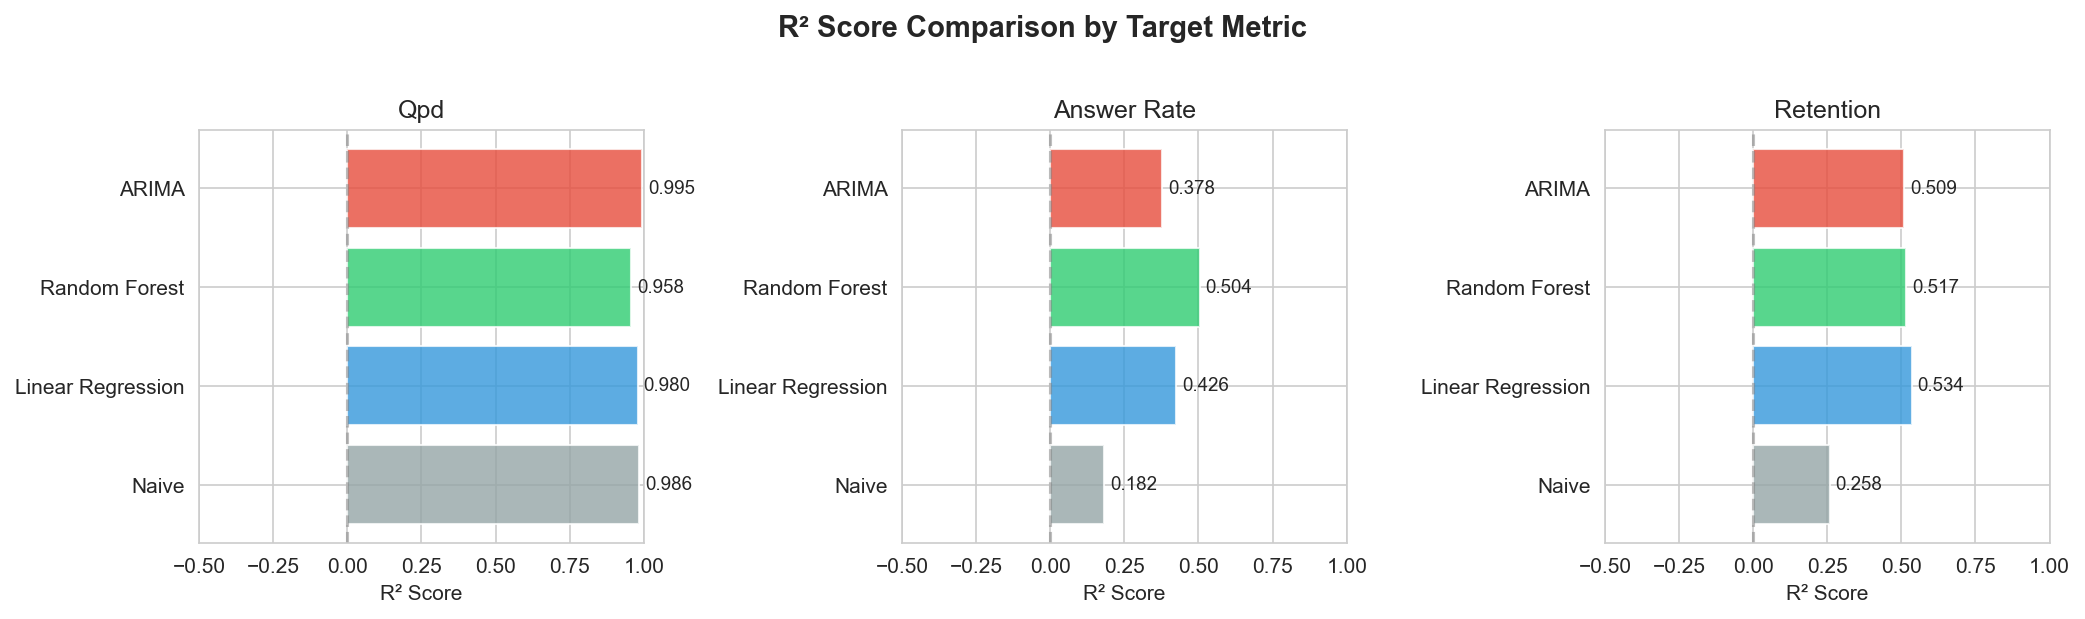

In [20]:
# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 150

# Color palette
model_colors = {
    'Naive': '#95a5a6',
    'Linear Regression': '#3498db',
    'Random Forest': '#2ecc71',
    'ARIMA': '#e74c3c'
}

# Figure 1: R² comparison
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

for idx, target in enumerate(['qpd', 'answer_rate', 'retention']):
    ax = axes[idx]
    
    models = list(all_results.keys())
    r2_values = [all_results[m][target]['r2'] for m in models]
    colors = [model_colors[m] for m in models]
    
    bars = ax.barh(models, r2_values, color=colors, alpha=0.8)
    ax.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
    ax.set_xlabel('R² Score')
    ax.set_title(f'{target.replace("_", " ").title()}')
    ax.set_xlim(-0.5, 1.0)
    
    # Add value labels
    for bar, val in zip(bars, r2_values):
        ax.text(val + 0.02, bar.get_y() + bar.get_height()/2,
               f'{val:.3f}', va='center', fontsize=9)

plt.suptitle('R² Score Comparison by Target Metric', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'r2_comparison.png', bbox_inches='tight', dpi=150)
plt.show()

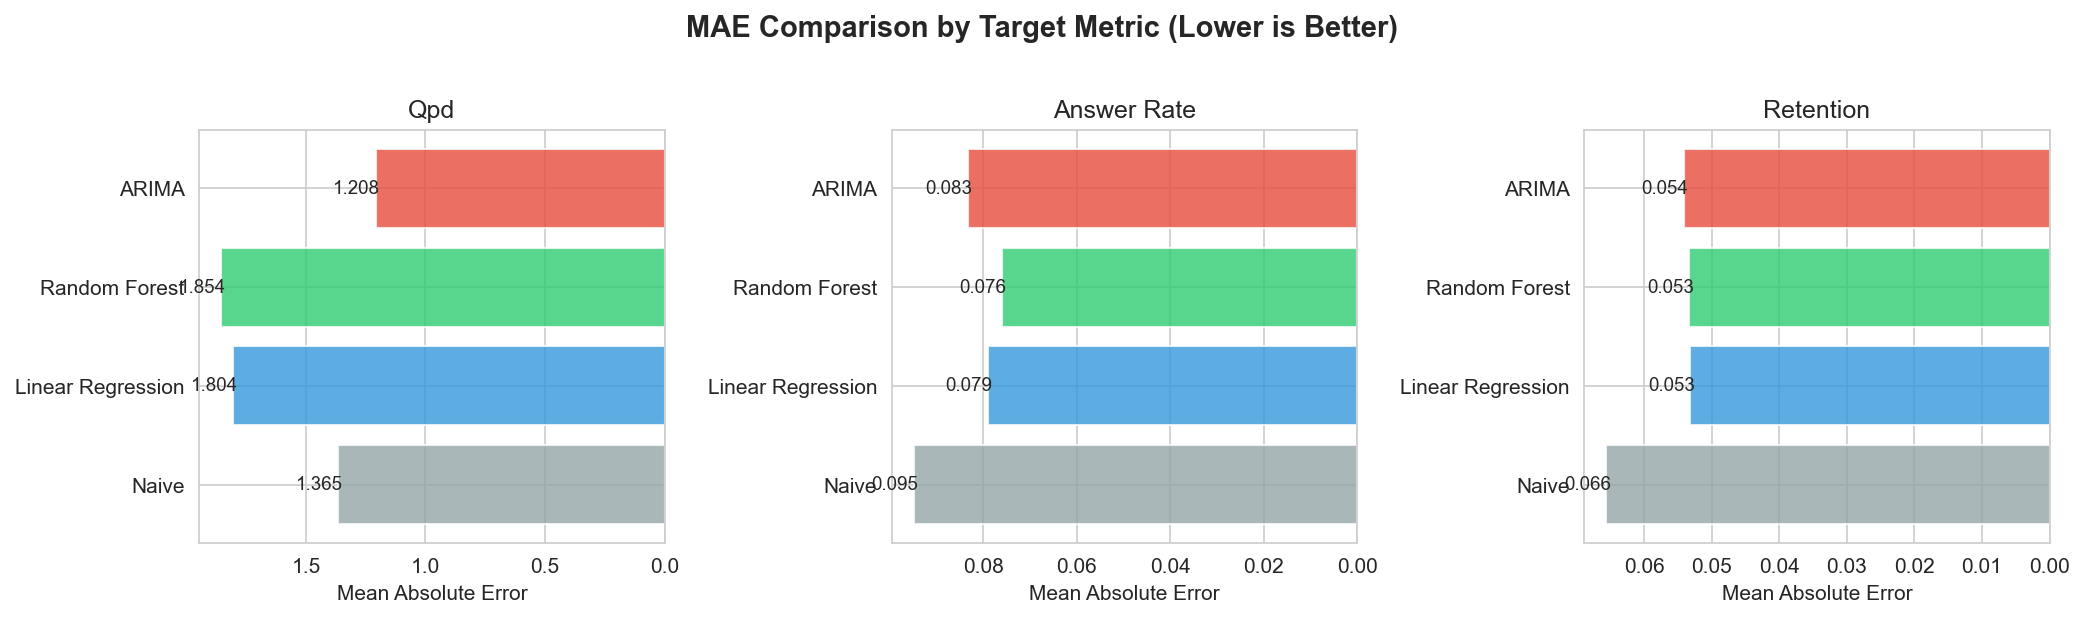

In [21]:
# Figure 2: MAE comparison
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

for idx, target in enumerate(['qpd', 'answer_rate', 'retention']):
    ax = axes[idx]
    
    models = list(all_results.keys())
    mae_values = [all_results[m][target]['mae'] for m in models]
    colors = [model_colors[m] for m in models]
    
    bars = ax.barh(models, mae_values, color=colors, alpha=0.8)
    ax.set_xlabel('Mean Absolute Error')
    ax.set_title(f'{target.replace("_", " ").title()}')
    ax.invert_xaxis()  # Lower is better
    
    # Add value labels
    for bar, val in zip(bars, mae_values):
        ax.text(val - 0.01 * max(mae_values), bar.get_y() + bar.get_height()/2,
               f'{val:.3f}', va='center', ha='right', fontsize=9)

plt.suptitle('MAE Comparison by Target Metric (Lower is Better)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'mae_comparison.png', bbox_inches='tight', dpi=150)
plt.show()

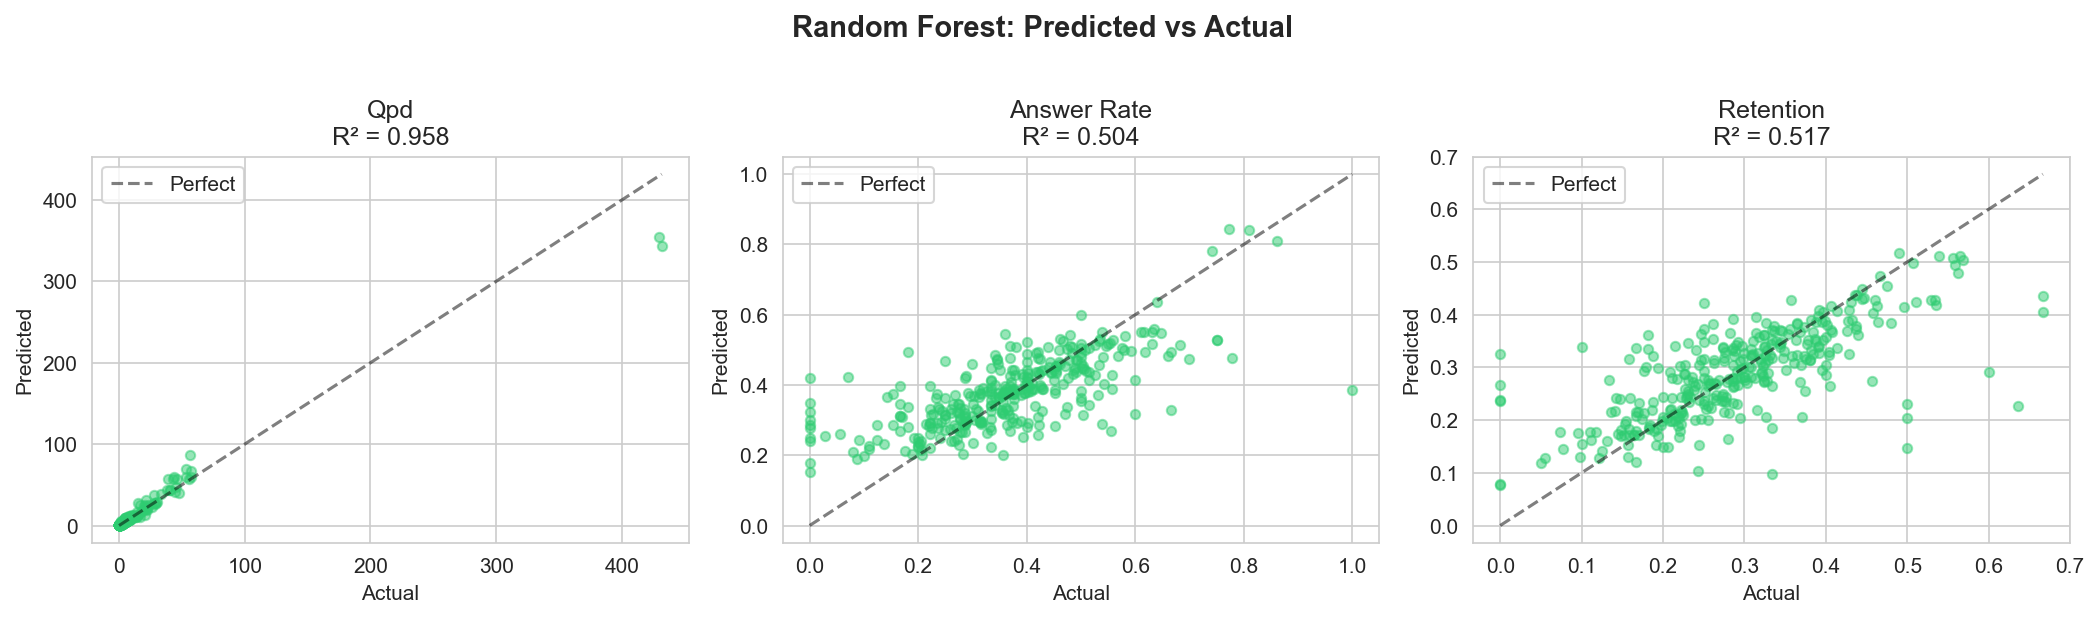

In [22]:
# Figure 3: Prediction vs Actual scatter plots for best model (Random Forest)
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

for idx, target in enumerate(['qpd', 'answer_rate', 'retention']):
    ax = axes[idx]
    
    y_true = y_val[target]
    y_pred = rf_predictions[target]
    
    ax.scatter(y_true, y_pred, alpha=0.5, s=20, c='#2ecc71')
    
    # Add diagonal line
    lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
    ax.plot(lims, lims, 'k--', alpha=0.5, label='Perfect')
    
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_title(f'{target.replace("_", " ").title()}\nR² = {rf_results[target]["r2"]:.3f}')
    ax.legend()

plt.suptitle('Random Forest: Predicted vs Actual', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'rf_scatter.png', bbox_inches='tight', dpi=150)
plt.show()

## 12. Save Results

In [23]:
# Save results to JSON
results_to_save = {
    'models': {}
}

for model_name, results in all_results.items():
    results_to_save['models'][model_name] = {
        'metrics': {}
    }
    for metric in ['qpd', 'answer_rate', 'retention']:
        results_to_save['models'][model_name]['metrics'][metric] = {
            'mae': float(results[metric]['mae']),
            'rmse': float(results[metric]['rmse']),
            'r2': float(results[metric]['r2'])
        }
    
    # Add mean metrics
    mean_mae = np.mean([results[m]['mae'] for m in ['qpd', 'answer_rate', 'retention']])
    mean_rmse = np.mean([results[m]['rmse'] for m in ['qpd', 'answer_rate', 'retention']])
    mean_r2 = np.mean([results[m]['r2'] for m in ['qpd', 'answer_rate', 'retention']])
    
    results_to_save['models'][model_name]['mean'] = {
        'mae': float(mean_mae),
        'rmse': float(mean_rmse),
        'r2': float(mean_r2)
    }

# Add metadata
results_to_save['metadata'] = {
    'train_samples': len(train_dataset),
    'val_samples': len(val_dataset),
    'feature_dim': X_train.shape[1],
    'normalization': config['norm_stats']
}

# Save
with open(RESULTS_DIR / 'results.json', 'w') as f:
    json.dump(results_to_save, f, indent=2)

print(f"Results saved to {RESULTS_DIR / 'results.json'}")

Results saved to ../results/baseline/results.json


In [24]:
# Save trained models
models_to_save = {
    'linear_models': linear_models,
    'rf_models': rf_models,
    'scaler': scaler,
    'norm_stats': norm_stats
}

with open(RESULTS_DIR / 'baseline_models.pkl', 'wb') as f:
    pickle.dump(models_to_save, f)

print(f"Models saved to {RESULTS_DIR / 'baseline_models.pkl'}")

Models saved to ../results/baseline/baseline_models.pkl


## 13. Summary

In [25]:
print("\n" + "="*70)
print("BASELINE RESULTS SUMMARY")
print("="*70)

print(f"\nDataset:")
print(f"  Training samples: {len(train_dataset)}")
print(f"  Validation samples: {len(val_dataset)}")
print(f"  Feature dimension: {X_train.shape[1]}")

print(f"\nBest performing model by mean R²:")
best_model = mean_comparison.index[0]
best_r2 = mean_comparison.loc[best_model, 'R²']
print(f"  {best_model}: R² = {best_r2:.4f}")

print(f"\nPer-target best models:")
for target in ['qpd', 'answer_rate', 'retention']:
    best = max(all_results.keys(), key=lambda m: all_results[m][target]['r2'])
    r2 = all_results[best][target]['r2']
    print(f"  {target}: {best} (R² = {r2:.4f})")

print(f"\nFiles saved:")
print(f"  {RESULTS_DIR / 'results.json'}")
print(f"  {RESULTS_DIR / 'baseline_models.pkl'}")
print(f"  {RESULTS_DIR / 'r2_comparison.png'}")
print(f"  {RESULTS_DIR / 'mae_comparison.png'}")
print(f"  {RESULTS_DIR / 'rf_scatter.png'}")

print("\n" + "="*70)
print("Baseline evaluation complete!")
print("These results can be compared directly with GNN performance.")
print("="*70)


BASELINE RESULTS SUMMARY

Dataset:
  Training samples: 1834
  Validation samples: 338
  Feature dimension: 124

Best performing model by mean R²:
  Random Forest: R² = 0.6598

Per-target best models:
  qpd: ARIMA (R² = 0.9947)
  answer_rate: Random Forest (R² = 0.5043)
  retention: Linear Regression (R² = 0.5342)

Files saved:
  ../results/baseline/results.json
  ../results/baseline/baseline_models.pkl
  ../results/baseline/r2_comparison.png
  ../results/baseline/mae_comparison.png
  ../results/baseline/rf_scatter.png

Baseline evaluation complete!
These results can be compared directly with GNN performance.
